In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

In [3]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
df.isna().sum() 

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [8]:
df.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
df.describe(include='O')

,headline,article_link
count,28619,28619
unique,28503,28617
top,"'no way to prevent this,' says only nation whe...",https://politics.theonion.com/nation-not-sure-...
freq,12,2


In [10]:
del df['article_link']

In [11]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [12]:
df.is_sarcastic.value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

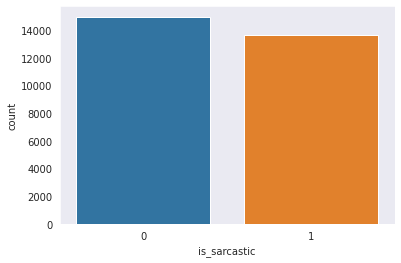

In [13]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [14]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [16]:
len(stop)

211

In [17]:
def remove_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    #text = remove_square_brackets(text)
    text = remove_stopwords(text)
    return text

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


In [18]:
df['headline']=df['headline'].apply(denoise_text)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [19]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails congress falling short ...
2,0,eat veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word 'streamin...


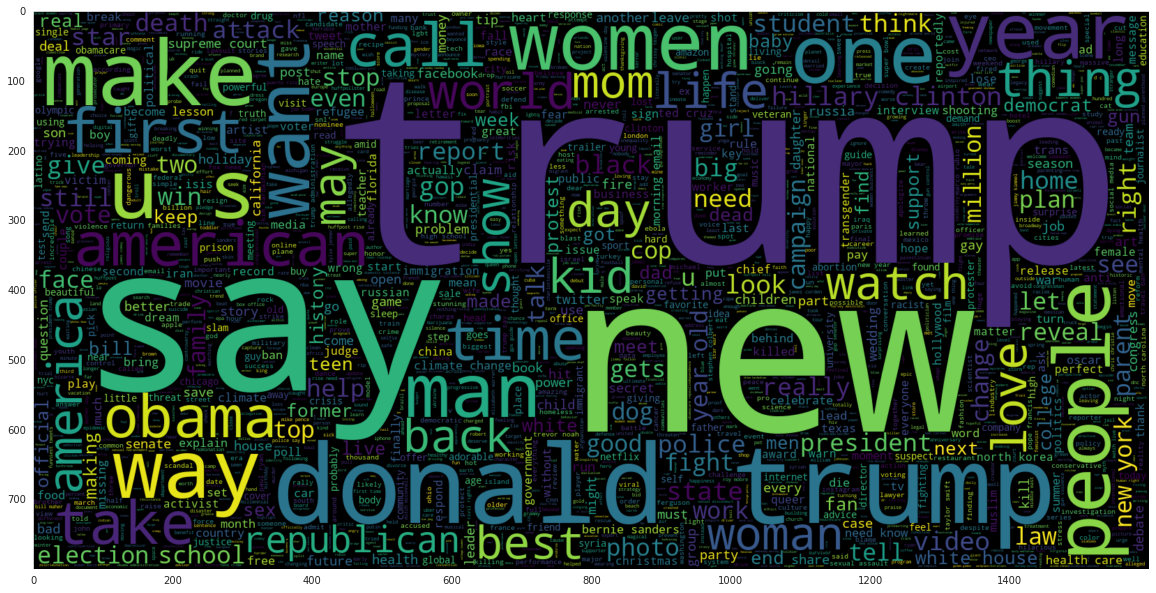

In [20]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

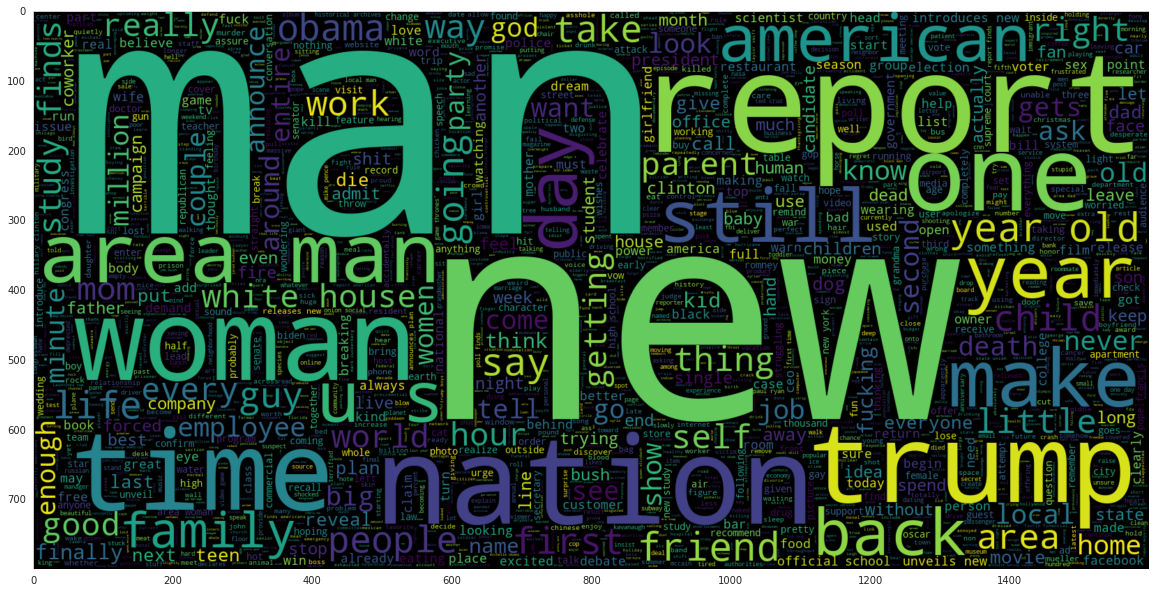

In [21]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

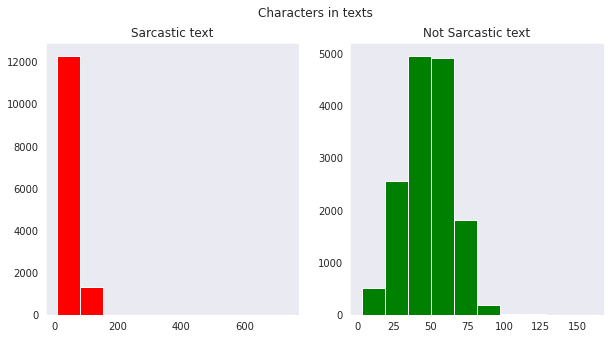

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

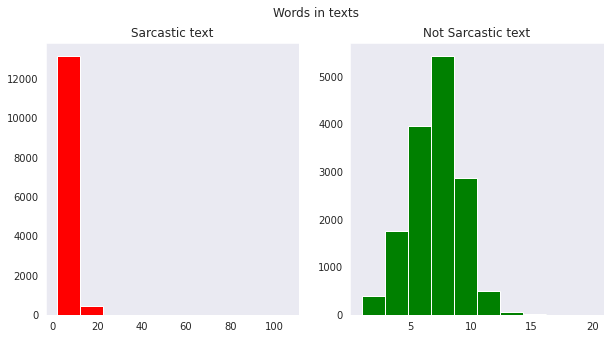

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

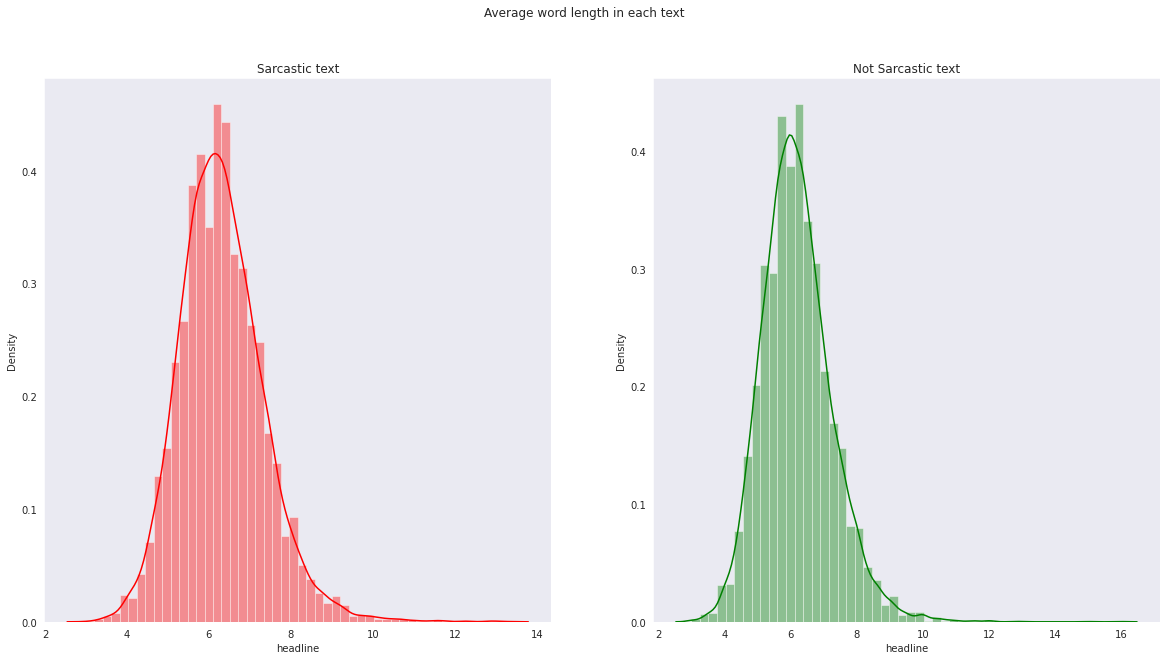

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

In [25]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'congress',
  'falling',
  'short',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'getting', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [27]:
import gensim
EMBEDDING_DIM = 200 # vector dimension
w2v_model = gensim.models.Word2Vec(sentences = words , 
                                   vector_size=EMBEDDING_DIM , 
                                   window = 5 , 
                                   min_count = 1)

In [30]:
word_vectors = w2v_model.wv
len(word_vectors)

38071

In [31]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [32]:
vocab_size = len(tokenizer.word_index) + 1

In [33]:
vocab_size

38072

In [39]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [40]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [41]:
embedding_vectors

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.52341098e-01, -3.58514696e-01,  2.34042078e-01, ...,
        -1.01225865e+00, -4.78215486e-01,  3.25156227e-02],
       [ 1.28239080e-01, -2.91974366e-01,  1.96561098e-01, ...,
        -8.76631141e-01, -4.05656397e-01, -9.66626313e-03],
       ...,
       [-8.31616111e-04, -5.83934598e-04,  1.47511688e-04, ...,
         5.82530978e-04, -5.63996192e-03,  4.73500928e-03],
       [ 1.01131084e-03, -4.79502045e-03, -3.05275596e-03, ...,
        -5.90775767e-03,  2.03896966e-03,  4.48971894e-03],
       [ 6.19744009e-04, -2.69488129e-03,  1.56656816e-03, ...,
        -7.93628022e-03, -4.63475008e-03,  3.54783307e-03]])

In [44]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 200)           7614400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,007,041
Trainable params: 8,007,041
Non-trainable params: 0
_________________________________________________________________


In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [47]:
history = model.fit(x_train, y_train, batch_size = 128 ,
                    validation_data = (x_test,y_test) ,
                    epochs = 5)

2022-12-09 06:03:00.560226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
157/157 [==============================] - 118s 653ms/step - loss: 0.5154 - acc: 0.7312 - val_loss: 0.4140 - val_acc: 0.8131
Epoch 2/5
157/157 [==============================] - 99s 630ms/step - loss: 0.1545 - acc: 0.9428 - val_loss: 0.5050 - val_acc: 0.8027
Epoch 3/5
157/157 [==============================] - 97s 617ms/step - loss: 0.0374 - acc: 0.9879 - val_loss: 0.7701 - val_acc: 0.8020
Epoch 4/5
157/157 [==============================] - 100s 636ms/step - loss: 0.0129 - acc: 0.9957 - val_loss: 1.1188 - val_acc: 0.7908
Epoch 5/5
157/157 [==============================] - 99s 629ms/step - loss: 0.0068 - acc: 0.9979 - val_loss: 1.1875 - val_acc: 0.7942


In [48]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

627/627 [==============================] - 49s 77ms/step - loss: 0.0032 - acc: 0.9991
Accuracy of the model on Training Data is -  99.9051570892334
269/269 [==============================] - 21s 78ms/step - loss: 1.1875 - acc: 0.7942
Accuracy of the model on Testing Data is -  79.41998839378357


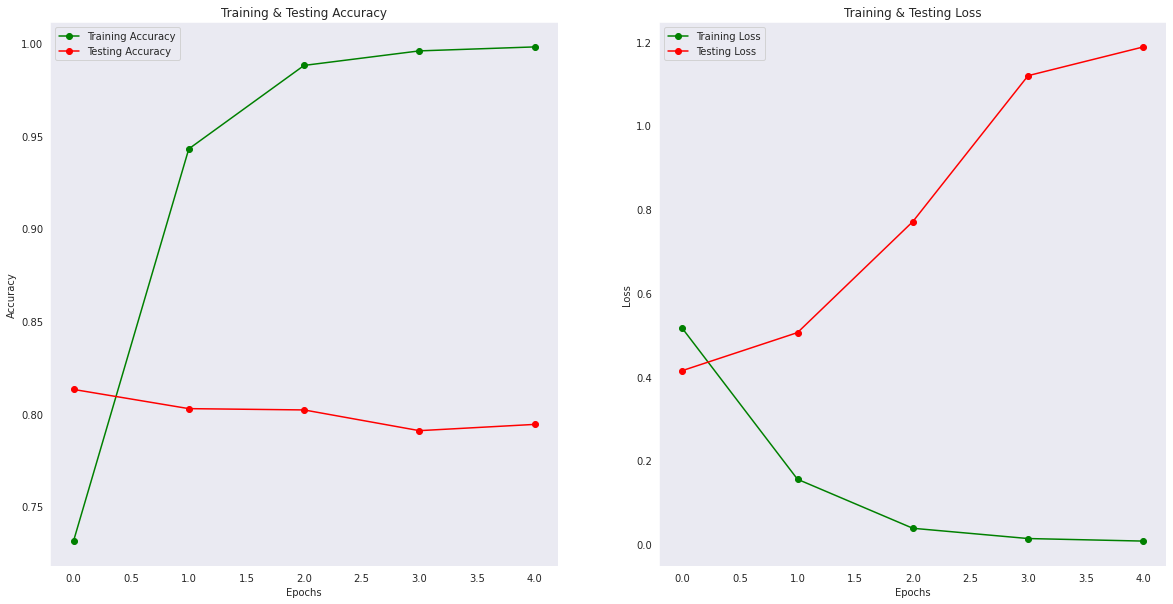

In [49]:
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [54]:
predict_x=model.predict(x_test) 
pred=np.argmax(predict_x,axis=1)
pred[:5]

array([0, 0, 0, 0, 0])

<AxesSubplot:>

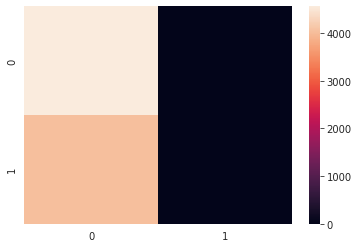

In [55]:
cm = confusion_matrix(y_test,pred)
sns.heatmap(cm)

<AxesSubplot:>

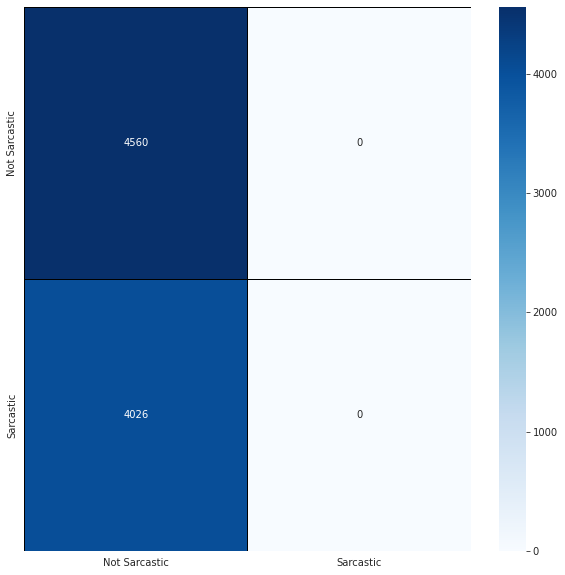

In [56]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

In [57]:
del embedding_vectors